# Introduction to Deep Learning


## Lecture Two

## Logistic Regression

Let's have a quick review of what we've covered so far.

![Linear regression](https://gluon.mxnet.io/_images/linear-regression.png)

https://gluon.mxnet.io/chapter02_supervised-learning/linear-regression-scratch.html

We started our introduction to the amazing world of deep learning by covering linear regression: a way to take a table of numerical data with a numerical label assigned to each row - and learn how to predict the value of such a label for the previously unseen rows.  This prediction is a linear combination of the input values, each one multiplied by some coefficient, or weight.  The task is to find these weights to optimize the fit.

![Gradient descent](https://miro.medium.com/max/1142/1*jNyE54fTVOH1203IwYeNEg.png)

https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3

We used an algorithm called gradient descent, which defines a loss function - essentially, the measure of how far we were off, on average, predicting the labels - and computed, for each weight, in which direction and by how much they needed to be changed to make the loss smaller.

![Supervised Machine Learning: a flowchart](https://www.danielforsyth.me/content/images/2014/Mar/plot_ML_flow_chart_1.png)

http://www.astroml.org/sklearn_tutorial/ (no longer live)

This is a summary-at-a-glance of a Machine Learning algorithm.  As input, we take data, expressed as many rows of numbers - here called feature vectors - and a label for each of those rows.  The algorithm computes the optimal weights to make sure the predicted labels are as close as possible to actual labels.  These weights, when computed, are called "the predictive model".  This allows us to take a new row of data - the one that the algorithm never saw before - and perform the same computation to assign a label to this new data.  If you recall, we predicted caloric value of cereal from its ingredients, car MPG as a function of its speed, etc. 

Today, we are going to make several aspects of this process more broad.  We will start by moving beyond numerical labels toward categorical labels - and then, inspired by the ideas that make that possible, move beyond numerical features into, first, categorical data, and then beyond.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None 
pd.options.display.precision = 3
pd.options.display.width = 256

%matplotlib inline
plt.style.use('seaborn')
for element in 'axes', 'xtick', 'ytick':
    plt.rc(element, labelsize = 16)

Let me start, as before, with importing the necessary libraries for plotting, matrix manupulation, and data loading.  I'll also set some parameters to make the display look nice.

In [2]:
# Dataset from http://users.stat.ufl.edu/~winner/datasets.html;
# description at http://users.stat.ufl.edu/~winner/data/gold_target1.txt

gold = pd.read_csv('http://users.stat.ufl.edu/~winner/data/gold_target1.dat', delim_whitespace = True,
                   names = ['arsenic', 'antimony', 'lineament', 'gold'], usecols = [0, 1, 3])
print(gold.head(10))

   arsenic  antimony  gold
0     6.77      3.08     1
1    15.03      6.15     1
2     6.43      2.35     1
3     0.10      0.30     0
4     0.10      0.30     0
5    41.48      9.62     1
6     0.10      0.51     0
7     6.01      3.71     1
8     0.20      4.32     0
9     0.20      0.80     0


As I've promised the last time, we are going to India to prospect for gold.

Here's the data set we are going to start with.  Each row here is a location, where a sample of a soil was taken.  First two columns are concentrations of arsenic and antimony in those samples; I honestly don't know in what units.  The last column is our label: whether gold was found in that location.  Notice that the gold column is a binary label: 1 for yes, 0 for no.  Also notice there are two input features here, both numerical - so we need an algorithm that takes numerical inputs and returns a binary label.  As a matter of fact, our algorithm will do better than that.  Not only it will produce the label, but it will also produce the confidence, or probability, that this label is correct.

As always, it's useful to start with a plot.

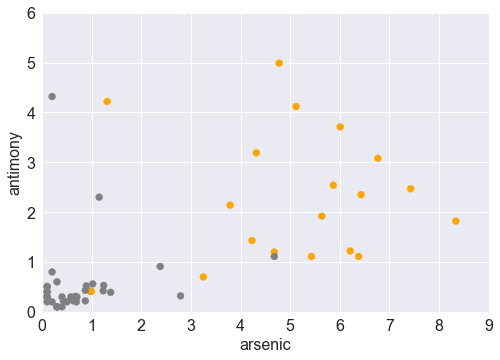

In [3]:
def plot_gold():
    plt.scatter(gold['arsenic'], gold['antimony'],
                color = gold['gold'].map({0: 'gray', 1: 'orange'}))
    plt.xlabel('arsenic')
    plt.ylabel('antimony')
    plt.xlim((0, 9))
    plt.ylim((0, 6))

plot_gold()
plt.show()

Here, the gray dots are locations without gold, and gold dots, naturally, correspond to gold.  Since we are now experts in linear regression and know everything about fitting lines to data, perhaps we can do the same here - only instead of trying to draw a line that minimizes the distance between the data points and the line, we would like to draw a line that optimizes the separation between our two classes of dots.  Something like this.

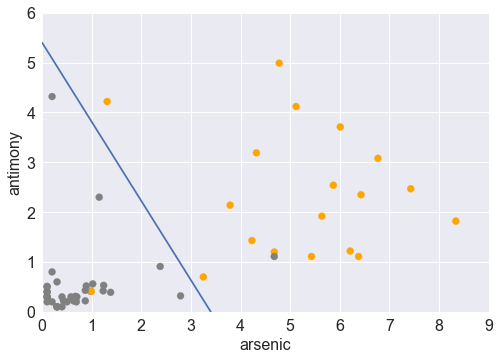

In [4]:
# Add a decision boundary
plot_gold()
plt.plot([0, 3.4], [5.4, 0])
plt.show()

This line is called decision boundary.  If I knew the equation for this decision boundary, I could predict that the points on one side should be labeled 1; points on the other side should get label 0.  This decision boundary I placed by hand.  Naturally, I will want the machine learning algorithm to do this for me.  Logistic regression is the process that uses gradient descent to place the decision boundary.

Notice there is a subtle but important difference between this plot and what we used to see in the cases of linear regression.  Last time, the X axis was the feature and the Y axis was the label.  This time, both X and Y axes are features, and the color of the dot is the label.  For this data set, I have two features, so I can plot them on a two-dimensional plot.  For more features, I need more dimensions.

### Decision boundary

![Decision boundary in three dimensions](http://3.bp.blogspot.com/-OVlHHKeYq28/Ukh6vBgVx3I/AAAAAAAACEI/5vw6LfK1xlY/s320/linearly_separable_4.png)

http://blog.sairahul.com/2014/01/linear-separability.html

In a three-dimensional feature space, the decision boundary is a plane.  For higher dimensions, it's a hyperplane.  In all cases, it is linear.

Here's a linear equation in an N-dimensional space.

$x_1 \cdot w_1 + x_2 \cdot w_2 + \ldots + x_N \cdot w_N + b = 0$

This is a simple linear combination of N features. b here is bias - so that we could define lines or planes that do not necessarily go through the origin point.

This equation looks simple but is a bit tricky, so let's stare at it for a while longer.  It says that if, for a particular point with coordinates x-one, x-two, etc., the value of the left hand side is zero, then this point belongs on the linear surface.

What happens if we compute the exact same expression for the point that is not on the decisiom boundary - for example, for one of our data points?  Since the point is not on the boundary, we'll get a number that is not zero.  What we will get, however, is the distance from the boundary.  Even better, this distance will come with a sign: for the points that are above the boundary, the distance will be positive.  For the points on the other side, the distance will be negative.

Now we are getting somewhere.  We'll use gradient descent to produce the coefficients - bias, w-one, w-two, etc - of the decision surface.  Then, for each new data point, we can plug the features - x-one, x-two, etc. - into the formula, and compute the result.  If this result is positive, we predict that this data point should receive label one.  If the result is negative, we predict that the label should be zero.

That sounds simple.  I am going to make it more complicated.  I will require more heavy lifting from this formula.  I would like it to produce not only the prediction, but also the confidence of this prediction.  If a data point is exactly on the decision boundary - if its distance is zero - I will say I am not confident at all and say it's a fifty percent chance label is one, fifty percent chance label is zero.  But the futher away from the decision boundary I am, the more confident my prediction is.

Now, the distance from the decision boundary can be anything - from minus infinity to plus infinity.  I need a way that converts this distance into the values from zero to one, which is the probability that this data point has a "true" label. What are the requirements for the function that performs this mapping?

$f(\infty) = 1.0$

<br>

$f(-\infty) = 0.0$

<br>

$f(0) = 0.5$

<br>

$f(-x) + f(x) = 1.0$

To start with, if my point is infinitely far above the decision boundary, I am certain the label is one.  If it's infinitely far below it, the chances that the label is one are exactly zero.  If I am on the decision boundary, the probability is one half. Also, the probability distrubution should be symmetrical: if I mirror my point to the opposite side of the decision boundary, and keep the same distance, the result should be complementary.

Here is one function that satisfies all of the above.

$\sigma(x) = \frac{1}{1 + e^{-x}}$

One over one plus exponent of minus x.  Check it out.  For large values of x, exponent of minus x is zero, so the function approaches one over one, which is one.  For large negative x, exponent of minus x is plus infinity, so the function approaches one over infinity, which is zero.  For x equals zero, exponent of zero is one, so the function is exactly one over two.  You can check yourself that the last requirement is satisfied.

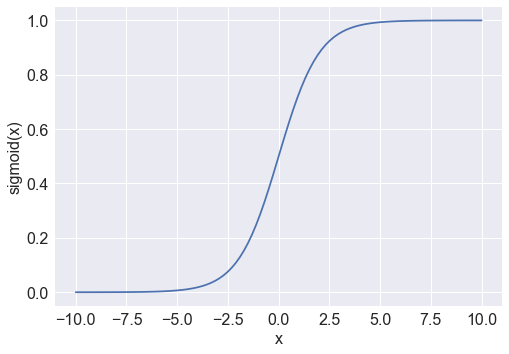

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x_range = np.linspace(-10, 10, 100)
plt.plot(x_range, [sigmoid(x) for x in x_range])
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.show()


This function belongs to a sigmoid family, called so because it looks sort of like the Greek letter Sigma, or the English letter S.  This is the logistic function.  Thus the name of algorithm: logistic regression.

Here's the idea behind logistic regression.  I am going to use exactly the same process as with linear regression: I will use gradient descent to fit the features into a linear formula - but I will use a very different loss function.

Let me first refresh your memory of the code we wrote the last time.

In [6]:
def hypothesis(X, W):
    return X @ W

def error(X, Y, W):
    return hypothesis(X, W) - Y

def gradient(X, Y, W):
    return error(X, Y, W).dot(X) / len(X)

def gradient_descent(X, Y, W, epochs, learning_rate):
    for _ in range(epochs):
        W = W - learning_rate * gradient(X, Y, W)
    return W

This code computes the hypothesis, which is the linear combination of our features; the error, which is by how much we are off; defines the gradient; and performs gradient descent.  Notice that I do not actually need to compute the loss itself - only the gradient of it.

Let's start changing this code.  The hypoothesis we need also computes the linear combination of the features, but then we need to convert this unbounded number - the distance from the decision boundary - into a probability.  To switch to the logistic regression hypothesis, all we need to do is wrap the linear combination in a sigmoid function.

In [7]:
def hypothesis(X, W):
    return sigmoid(X @ W)

Great.  A small change, so far.  We will clearly need to do a dramatic rewrite of the rest of the code.  I will show how dramatic when we get there.

We have a new hypothesis.  We need to define a new loss function and compute its gradient.

This new logistic loss function should not attempt to minimize the distance between the line and the data points.  It should do the opposite: it should maximize the distance between the data points and the decision boundary.  The distance should be taken with the correct sign: points labeled one should be as far as possible above the boundary, the points labeled zero as far as possible below it.  As a matter of fact, I will have the points that are on the correct side of the decision boundary contributing negative amounts of loss.  This way, when we minimize the loss, we will increase the number of data points on the correct side of it.

Any other requirements for such a loss function?  I can think of two.

Remember how the last time we wanted the outliers to contribute to the loss disproportionately, so we used error squared?  Now, the situation is different.  I don't want the outliers to conribute disproportionately, not even linearly, because, after all, what truly matters is that they are on the correct side.

The second requirement has to do with the grand philosophical principle I've established the last time.  I want my loss function to easy to find the gradient of.

That said, here's the formula for the logistic hypothesis, which you've seen before, plus the formula for the logistic loss.

### Logistic hypothesis

$H(X) = H(x_1, x_2, \ldots, x_N) = \sigma(x_1 \cdot w_1 + x_2 \cdot w_2 + \ldots + x_N \cdot w_N + b)$

### Logistic loss

$Loss(X, Y) = - Y \cdot ln(H(X)) - (1 - Y) \cdot ln(1 - H(X))$

The loss formula looks complex, but is actually exceedingly simple.  The key to understanding this formula is that the label Y can be only 0 or 1, and that means that out of the two parts of this formula only one is ever non-zero.

If Y is one, the first term is non-zero, and it's simply the logarithm of our distance from the boundary, with the minus sign.  This means that for the data points that should be labeled one, the higher we are above the boundary, the better.  If Y is zero, the second term is non-zero, which is exactly the same - only it has one minus the hypothesis, which means we are rewarding the distance under the decision boundary.

The logarithm is there to make the relationship a bit less steep than linear and to make the formula easy to differentiate, as we'll see shortly.  Each term has a minus sign on front of it, to make sure that the best fit corresponds to the lowest loss.

Now comes the real work.  To be able to use gradient descent for logistic regression, we need to be able to compute the slope of the loss function in respect to the weights.  If we know that formula, we'll be able to compute the gradient, nudge each weight in the direction opposite to the gradient, and reduce the loss.  Repeat until converged at the smallest loss.

### Logistic loss, rewritten

$L = - Y \cdot ln(H) - (1 - Y) \cdot ln(1 - H)$

$H = \frac{1}{1 + e^{-A}}$

$A = X \cdot W + b$

### Chain rule to the rescue

$\frac{d f(g(x))}{d x} = \frac{d f(g(x))}{d g(x)} \cdot \frac{d g(x)}{dx}$

### Useful to know

$\frac{d e^x}{dx} = e^x$

$\frac{d \ln{x}}{dx} = \frac{1}{x}$

Here's the whole nitty-gritty.  The loss depends on the hypothesis, which equals the sigmoid function applied to the linear combination of features.  I am sure the House that Jack Built is also involved somehow.

However, just like with linear regression, we can use the chain rule, which helps us to find gradients of the functions that can be written in exactly this way: nested.  Loss is the function of hypothesis which is the function of the linear combination of features which is the function of the weights.  Great - this is exactly what we need.

As far as differentiating simple, non-nested, functions, we've covered several helpful formulae during the previous lecture.  We need two more: the derivative of an exponent is the exponent; it's the only function other than Y = 0 that equals its own derivative.  Also, the derivative of a natural logarithm is the inverse of the argument.

Great.  We're all set to apply the chain rule to the logistic loss.

### Logistic loss derivative

$\frac{dL}{dW} = \frac{dL}{dH} \cdot \frac{dH}{dA} \cdot \frac{dA}{dW}$

$\frac{dL}{dH} =  \frac{1 - Y}{1 - H} - \frac{Y}{H}$

$\frac{dH}{dA} = H \cdot (1 - H)$

$\frac{dA}{dW} = X$

See https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression for details.

I've separated the derivative into three derivatives, using the chain rule, and then computed each one separately.  The first one uses the log gradient; the second one uses the exponent gradient; the last one is elementary.  Feel free to write out the math yourselves or check this link for the full derivation.

All I need to do now is to combine all of this into one product.  The result is remarkably simple.

### Combining all of the above

$\frac{dL}{dW} = (H - Y) \cdot X$

Some of you might have noticed something curious here.  Not only this formula for the logistic loss gradient is simple - it also happens to be the exact same formula as the loss gradient in the case of linear regression.  Hypothesis minus the true label is error, which is by how much we are off.  X is the feature whose weight you are currently adjusting.

This is amazing.  Not a coincidence, of course: this is because we picked the loss function that's easy to differentiate.  Let's take the look at our code.

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hypothesis(X, W):
    return sigmoid(X @ W)

def error(X, Y, W):
    return hypothesis(X, W) - Y

def gradient(X, Y, W):
    return error(X, Y, W).dot(X) / len(X)

def gradient_descent(X, Y, W, epochs, learning_rate):
    for _ in range(epochs):
        W = W - learning_rate * gradient(X, Y, W)
    return W

After all of this work, the only change we had to make to the linear regression code is changing the hypothesis to wrap the linear combination of features inside a sigmoid.

This is it.  The error is computed in the same way.  The gradient computation is the same.  The gradient descent code is the same.  Everything else we've discussed before - learning rate, separating data into train and test sets, making sure not to overfit - applies in exactly the same way.

Now everything is ready.  Let's run the gradient descent, optimize the weights, and plot the decision boundary.

W = [ 1.249  0.923 -4.966]


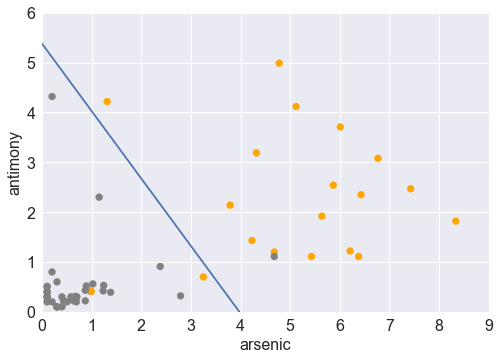

In [9]:
gold['bias'] = 1

X = gold[['arsenic', 'antimony', 'bias']].values
Y = gold['gold']
W = gradient_descent(X, Y, np.zeros(X.shape[1]), 10000, 0.1)

print('W =', np.round(W, 3))

plot_gold()
plt.plot([0, -W[2] / W[0]], [-W[2] / W[1], 0])
plt.show()

Note that this decision boundary is slightly different from mine - there is an extra data point with the gold label on the wrong side.  This does not mean, however, that this decision boundary is worse.  As we've discussed, the correct way to measure the accuracy is not on the training data, but on the data the algorithm has never seen before, known as test data.  I am not going to bother with the train-and-test split in this case, because the data set is very small.  But we'll do that when our data sets get bigger.  We will, however, compute the train set accuracy, just to show that we are doing quite well.

In [10]:
def accuracy(X, W, Y):
    predictions = hypothesis(X, W) > 0.5
    return (predictions == Y).mean()

print('accuracy = {:.3f}'.format(accuracy(X, W, Y)))

accuracy = 0.953


Here we go.  This computes the hypothesis and predicts the positive label when the confidence is above one half.  This gives us 95 percent accuracy with about a dozen lines of code.

One interpretation of logistic regression that makes a lot of sense to me is this.  You can think of it as a process that assigns points to different features.  Each location gets a certain amount of points for each unit of anitimony, plus a different amount of points for every unit of arsenic, plus a fixed amount of points just because, and then if the total points are positive, it's more likely than not that the label should be one.  Otherwise, zero.  This way of interpreting logistic regression - different features accruing different amounts of points - will be helpful in the future, when we are dealing with more varying feature types.

Time to switch to another data set - perhaps one of the most famous data sets in the history of data science.

![Titanic](https://upload.wikimedia.org/wikipedia/commons/6/6e/St%C3%B6wer_Titanic.jpg)

The sinking of the Titanic.  The panic at the lifeboats, "women and children first", you know the story.  Let's see if the popular conception is supported by cold, hard data.

In [11]:
# Dataset from http://jse.amstat.org/v3n3/datasets.dawson.html;
# description at http://jse.amstat.org/datasets/titanic.txt

titanic = pd.read_csv('http://jse.amstat.org/datasets/titanic.dat.txt', delim_whitespace = True,
                      names = ['class', 'is_adult', 'is_male', 'survived'])
print(len(titanic), 'rows available\n')
print(titanic[317:327])

2201 rows available

     class  is_adult  is_male  survived
317      1         1        0         0
318      1         1        0         0
319      1         0        1         1
320      1         0        1         1
321      1         0        1         1
322      1         0        1         1
323      1         0        1         1
324      1         0        0         1
325      2         1        1         1
326      2         1        1         1


We have the data for everyone who sailed on the Titanic: twenty-two hundred and one person, both passangers and crew.  This data contains, for everyone on board, age group - adult or child, gender - male or female, class - first, second, third, or zero, meaning crew, and, finally, the binary label column: whether they have survived or not. I've displayed a little slice of data as an example.  Eight passengers from the first class, two passengers from the second. Let's run some quick statistics, just to get an idea of the distribution of these values - another good idea.

In [12]:
print(titanic.apply(pd.Series.value_counts))

   class  is_adult  is_male  survived
0    885     109.0    470.0    1490.0
1    325    2092.0   1731.0     711.0
2    285       NaN      NaN       NaN
3    706       NaN      NaN       NaN


Here we go.  885 crew members.  325 passengers in the first class.  109 children.  470 women.  711 survivors.

You probably noticed one curious aspect of this data.  It's not just that the label is categorical.  The feature themselves are categorical.  is_adult and is_male columns are, just like the label, binary.  The class column is categorical but not binary - it contains four different values.  We know how to deal with the categorical label - we use logistic regression.  How do we deal with the categorical data?

We can easily deal with the categorical data that is binary, such as is_male and is_adult.  We can simply treat them as numerical labels: every person starts with the fixed number of points - this is bias.  Then you get a certain - possibly negative - amount of points if you're male, plus a different - also possibly negative - amount of points - if you are an adult.  Then, if your points total is positive, contgratulations!  You did not drown!

We cannot do that with the class column.  We can certainly assign zero points to crew and a certain amount of points to the first class passengers - but we cannot assign twice that number of points to the second class and thrice as much to the third class.  We need to have separate - and unrelated - amounts of points for each class.

What we should do is to pick one class as default - just like we did with children and women.  Adults and males get points - again, possibly negative.  Children and women don't.  Let's take crew as this default class.  Then we have to come up with three different weights: you get one weight added to your total if you're in first class, another, different weight if you're in the second class, and the third weight if you are in steerage.  This means that instead of one column with four different values, we should have three binary columns.  Column one: are you a first class passenger, yes or no?  Second column: second class, yes, or no?  Third column: third class?  If all these columns contain zero for a particular person, the she or he belongs to the crew.

Notice we need one fewer columns than the number of the values.  If the feature is binary, we need one column.  For four values, we need three columns.

This way of encoding one column with N discrete categorical values as N - 1 binary columns is called One Hot Encoding.  Here's an example.

In [13]:
print(pd.get_dummies([0, 1, 2, 3, 0], drop_first = True))

   1  2  3
0  0  0  0
1  1  0  0
2  0  1  0
3  0  0  1
4  0  0  0


There is a convenient helper function in the pandas package, called get dummies, and it does exactly what you need: it drops the lowest value of the categorical feature, and converts every other value into a separate binary column.  In this example, I have a toy data set with one feature, which takes values between zero and three.  The function counts how many different values this feature has and then converts the single input list into the correct number of columns.  The data point at the beginning has the value 0, so the top row of my matrix has zeroes across all three feature columns; the next point has the value 1, so it gets a value 1 in the column one and zeroes elsewhere.  Same with the the next two values getting a binary flag in the correct column.  The final value is again zero, so again all the columns in the bottom row are empty.

In [14]:
titanic_one_hot = pd.concat([pd.get_dummies(titanic[col], drop_first = True, prefix = col)
                             for col in titanic.columns if col != 'survived'], axis = 1)
titanic_one_hot['bias'] = 1
print(titanic_one_hot[317:327])

     class_1  class_2  class_3  is_adult_1  is_male_1  bias
317        1        0        0           1          0     1
318        1        0        0           1          0     1
319        1        0        0           0          1     1
320        1        0        0           0          1     1
321        1        0        0           0          1     1
322        1        0        0           0          1     1
323        1        0        0           0          1     1
324        1        0        0           0          0     1
325        0        1        0           1          1     1
326        0        1        0           1          1     1


Here's the same slice of our data set after is has been one-hot-encoded; notice that for the eight passengers from the first class, the first column has a one; for the last two rows, the second column has ones.  I've also added the bias column. Notice that is_adult and is_male require only one column, which is identical to what they were before one-hot-encoding.  The class column get mapped to three columns, with the crew members not receiving a separate column.  They get their points included into the bias; the same for children and females.

Now that we have our data, we can run logistic regression to optimize the weights for all of these features.

In [15]:
W = gradient_descent(titanic_one_hot.values, titanic['survived'],
                     np.zeros(len(titanic_one_hot.columns)), 50000, 0.1)

for feature, weight in zip(titanic_one_hot.columns, W):
    print('{:+.3f}\t{}'.format(weight, feature))
    
acc = accuracy(titanic_one_hot.values, W, titanic['survived'])
dominant_label_frequency = max(titanic['survived'].value_counts(normalize = True))
print('\naccuracy = {:.3f} (dominant label frequency = {:.3f})'.format(acc, dominant_label_frequency))

+0.858	class_1
-0.160	class_2
-0.920	class_3
-1.062	is_adult_1
-2.420	is_male_1
+2.248	bias

accuracy = 0.778 (dominant label frequency = 0.677)


These weights do tell a story.  Notice the large positive weight for the first class and the large negative weight for the third.  Also notice the negative weights for males and adults.  I guess it was "women and children first".

One thing that is very useful to compute for the data set is the frequency of the dominant - that is, the most common - label.  This provides the lowest boundary for the acceptable accuracy of a classifier.  After all, I can build a very simple, very pessimistic, classifier that predicts that everyone will drown.  It will have the accuracy of 68%.  Whatever classifier we build, it should do better than that.

We are doing better than that, predicting the label with 78% accuracy.

In [16]:
print('probability (female + child + crew) = {:.3f}'.format(sigmoid(W[-1])))
print('probability (male + adult + first class) = {:.3f}'.format(sigmoid(W[0] + W[3] + W[4] + W[-1])))
print('probability (male + adult + third class) = {:.3f}'.format(sigmoid(W[2] + W[3] + W[4] + W[-1])))
print('probability (female + adult + third class) = {:.3f}'.format(sigmoid(W[2] + W[3] + W[-1])))

probability (female + child + crew) = 0.904
probability (male + adult + first class) = 0.407
probability (male + adult + third class) = 0.104
probability (female + adult + third class) = 0.566


Now we can use these weights to predict the probabilities.  For example, there were no female children on board that were part of the crew, and yet we can predict the survival probabiility.  This is simply the sigmoid of our bias.  For an adult first class male, we add the bias, plus the weights for male, adult, and first class, and take sigmoid of that.

So far, we used logistic regression for numerical features and for categorical features.  One-hot-encoding the categorical features, by the way, is perfectly useful for linear regression as well.

Are there any other types of data we might want to apply regression to?  Sure.  Let's see how we can use logistic regression if our data is text.

In [17]:
# Data via https://www.researchgate.net/publication/258050002_SMS_Spam_Collection_v1
spam = pd.read_csv('https://www.researchgate.net/profile/Tiago_Almeida4/publication/' +
                   '258050002_SMS_Spam_Collection_v1/data/00b7d526d127ded162000000/' +
                   'SMSSpamCollection.txt', delimiter = '\t', names = ['label', 'text'])
print(len(spam), 'rows')
for row in (1118, 198):
    print('\n{}:\n{}'.format(spam['label'][row], spam['text'][row]))

5572 rows

spam:
449050000301 You have won a £2,000 price! To claim, call 09050000301.

ham:
is your hamster dead? Hey so tmr i meet you at 1pm orchard mrt? 


This is the famous text message spam data set: five and a half thousand text messages from UK and Singapore.  It's very simple, as far as data sets go, with only two columns.  One column is the full text of the message.  Another one is the label, ham or spam.  These examples are quite characteristic.  Perhaps we can use the content of the message to decide whether it is spam or ham.  After all, spammers hardly ever inquire about the health of your hamster.

I hope you've noticed that we are increasingly looking into use cases that would be quite difficult to solve without machine learning.  After all, reading a text message and deciding if it is spam feels like an example of conscious thought - not something that computers usually excell at.

What can we do with this data?  The content of the message is expressed in words, so let's extract all the words from every message.

In [18]:
spam['split'] = spam['text'].str.lower().str.findall('[a-z0-9]+')
print(spam.head(10))

  label                                               text                                              split
0   ham  Go until jurong point, crazy.. Available only ...  [go, until, jurong, point, crazy, available, o...
1   ham                      Ok lar... Joking wif u oni...                     [ok, lar, joking, wif, u, oni]
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...  [free, entry, in, 2, a, wkly, comp, to, win, f...
3   ham  U dun say so early hor... U c already then say...  [u, dun, say, so, early, hor, u, c, already, t...
4   ham  Nah I don't think he goes to usf, he lives aro...  [nah, i, don, t, think, he, goes, to, usf, he,...
5  spam  FreeMsg Hey there darling it's been 3 week's n...  [freemsg, hey, there, darling, it, s, been, 3,...
6   ham  Even my brother is not like to speak with me. ...  [even, my, brother, is, not, like, to, speak, ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...  [as, per, your, request, melle, melle, oru, mi...
8  spam  W

We are not doing anything elaborate here.  We are simply converting the string to lowercase and extracting all contiguous sequences of letters, known as tokens.  True, this will split words like "don't" into two tokens.  If you want to use a better token extractor, you are welcome to try.

Next: there are certainly many different tokens in our corpus.  Let's count how many tokens we have, and how many times each one is seen in the data.

In [19]:
from collections import Counter

terms = Counter(token for message in spam['split'] for token in message)
print(len(terms), 'terms found\n')

features = [term[0] for term in terms.most_common(100)]
print(features)

8745 terms found

['i', 'to', 'you', 'a', 'the', 'u', 'and', 'in', 'is', 'me', 'my', 'it', 'for', 'your', 'of', 'call', 'that', 's', 'have', 'on', '2', 'now', 'are', 't', 'can', 'so', 'but', 'not', 'm', 'or', 'do', 'we', 'at', 'ur', 'get', 'if', 'will', 'be', 'with', 'just', 'no', 'this', '4', 'gt', 'lt', 'how', 'up', 'when', 'ok', 'what', 'free', 'from', 'go', 'all', 'out', 'll', 'know', 'good', 'like', 'then', 'got', 'there', 'day', 'come', 'was', 'he', 'its', 'am', 'time', 'only', 'love', 'send', 'want', 'text', 'as', 'txt', 'one', 'by', '1', 'going', 'don', 'need', 'home', 'she', 'about', 'lor', 'r', 'sorry', 'stop', 'today', 'see', 'still', 'n', 'back', 'da', 'dont', 'our', 'reply', 'k', 'd']


Here're the 100 most common tokens.  I am going to ignore the rest, and I will so for three reasons.  First, the tokens that are seen in a few messages only will not help me to classify the rest.  Second, the infrequent tokens have noisy statistics - we can hardly hope to extract a useful trend out of them.  Finally - if you remember the previous lecture - we do not want to overfit.  After all, we are building a classifier to process the previously-unseen text messages, not the ones that are in this set.  We want logistic regression to find the patterns that are applicable to the entire universe of text messages.  A useful rule of thumb is that you want at least ten rows of data for each weight in your model.  Let's start with a hundred most frequent terms - this will give us a hundred features.

So what is the feature?  How can we represent a text message as a row of numbers?

We'll use the so-called bag of words model.  It ignores the positions of the words in the message, their context, and even their counts.  All we care about, for each of the hundred tokens we decided to track, is this: is this token present in this message? If yes, the feature is one.  Otherwise, it's zero.  This way, each text message is represented with a row of hundred binary numbers.  The first number tells you if the message contains the token "i"; the second number corresponds to the token "to"; and so on.

I am using Python, so I can code all this in one line.

In [20]:
X = np.array([[int(feature in message) for feature in features] for message in spam['split']])
print(X.shape, X, sep = '\n\n')

(5572, 100)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]]


Great.  Now I have my features.  Each row is a document.  Each column corresponds to a token's presense in a given document.

Now we need our labels, and that's even more straigtforward.

In [21]:
Y = np.array([label == 'spam' for label in spam['label']], dtype = np.int)
print(Y[:10])

[0 0 1 0 0 1 0 0 1 1]


Label 1 means this message is spam, 0 means otherwise.

Since this set is reasonably large, I can do the right thing and split it into train and test sets.  There is a nice helper function that does it for me.

In [22]:
from sklearn.model_selection import train_test_split
from statsmodels.api import add_constant

X_train, X_test, Y_train, Y_test = train_test_split(add_constant(X), Y, train_size = 0.9, random_state = 10000)

Let's use 90% of the data for training and the rest for testing.  I am using another helper function to add the bias column.  Also note I always specify a random seed in all my sampling code, to ensure repeatability.

We're all set to run gradient descent.

In [23]:
W = gradient_descent(X_train, Y_train, np.zeros(X_train.shape[1]), 1000, 1.0)
print('test set accuracy = {:.3f}'.format(accuracy(X_test, W, Y_test)))
print('dominant class frequency = {:.3f}'.format(max(np.mean(Y_test), 1 - np.mean(Y_test))))

test set accuracy = 0.975
dominant class frequency = 0.885


The elementary bag of words model that considers only the top 100 terms gives us 97.5% accuracy.  The naive classifier would have labeled everything as ham, produced an impressive 88.5% accuracy, and would have been entirely useless.

At this point, you should have questions.  Can we make this better?  Is training for 1000 epochs optimal?  Is using the top 100 terms optimal?  Let's investigate.

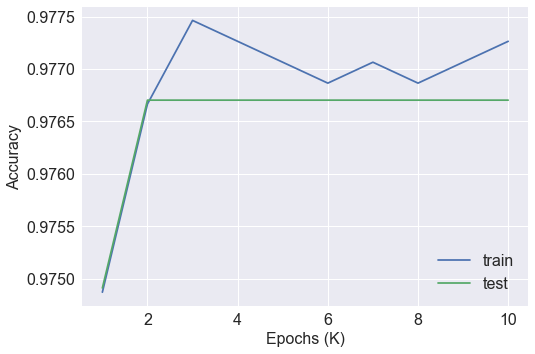

In [24]:
train_accuracy, test_accuracy = [], []
W = np.zeros(X_train.shape[1])
for thousand_epochs in range(10):
    W = gradient_descent(X_train, Y_train, W, 1000, 1.0)
    train_accuracy.append(accuracy(X_train, W, Y_train))
    test_accuracy.append(accuracy(X_test, W, Y_test))
    
plt.plot(range(1, 11), train_accuracy)
plt.plot(range(1, 11), test_accuracy)
plt.legend(['train', 'test'], loc = 'lower right', fontsize = 16)
plt.xlabel('Epochs (K)')
plt.ylabel('Accuracy')
plt.show()

Please recall that we don't really care for the training test accuracy.  We care about how well we are doing on the test set, which is the previously-unseen data.

Here, I've trained the classifier for ten thousand epochs, and every thousand epochs I've recorded the train and test set accuracies.  Notice that the training set accuracy peaks at three thousand, while the test set reaches the plateau at two thousand epochs.  This means we do not need to train past two thousand.

Now that I know this, let me repeat this process, only this time I will vary the count of the features.

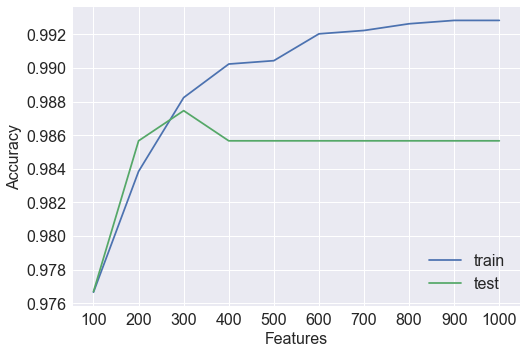

In [25]:
train_accuracy, test_accuracy = [], []
feature_counts = list(range(100, 1100, 100))
for feature_count in feature_counts:
    features = [term[0] for term in terms.most_common(feature_count)]
    X = np.array([[int(feature in message) for feature in features] for message in spam['split']])
    X_train, X_test, Y_train, Y_test = train_test_split(add_constant(X), Y, train_size = 0.9, random_state = 10000)
    W = gradient_descent(X_train, Y_train, np.zeros(X_train.shape[1]), 2000, 1.0)
    train_accuracy.append(accuracy(X_train, W, Y_train))
    test_accuracy.append(accuracy(X_test, W, Y_test))
    
plt.plot(feature_counts, train_accuracy)
plt.plot(feature_counts, test_accuracy)
plt.xticks(feature_counts)
plt.legend(['train', 'test'], loc = 'lower right', fontsize = 16)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.show()

We get a very similar picture.  As we increase feature count, the train set accuracy keeps increasing, which looks good but is really not, since the model is overfit, and the test accuracy drops.  The optimal point is at three hundred features.  Since we have about 5000 rows in our training set and we usually need about ten rows per feature, we can expect the overfitting to start around 500 features, which does indeed happen.

In [26]:
print('best accuracy (bag-of-words model) = {:.3f}'.format(max(test_accuracy)))

best accuracy (bag-of-words model) = 0.987


The correct choice of the feature cardinality and training length got our accuracy up to almost 99%.

If we had large documents, we could also use n-grams, which are contiguous sequences of tokens, like "good morning" or "make money fast".  They are frequently a good idea, but not here - the documents are too short.

Can we do better?

This is a silly question.  Of course we can do better.  Let's do what proper data science people do and stare at the data.

In [27]:
for text in spam['text'][spam['label'] == 'spam'].head(10):
    print(text[:100] + '...')

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr...
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it s...
WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim...
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera f...
SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6day...
URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to ...
XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> h...
England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 870...
Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by r...
07732584351 - Rodger Burns - MSG = We tried to call you re your 

This is a sample of spam messages.  Do you notice something peculiar about them?

They have a lot of numbers.  Our features were comprized entirely of letters and therefore we ignored numbers.

Let me add one more feature: a single column that is a simple count of all digits in the message.

In [28]:
features = [term[0] for term in terms.most_common(300)]
X = np.hstack([
    np.array([[int(feature in message) for feature in features] for message in spam['split']]),
    spam['text'].str.count('[0-9]').reshape(-1, 1)
])
X_train, X_test, Y_train, Y_test = train_test_split(add_constant(X), Y, train_size = 0.9, random_state = 1)
W = gradient_descent(X_train, Y_train, np.zeros(X_train.shape[1]), 2000, 1.0)
print('best accuracy (new model) = {:.3f}'.format(accuracy(X_test, W, Y_test)))

best accuracy (new model) = 0.995


Just this single additional feature increases the test set accuracy to 99.5%.  Again, these are the documents the model has never seen.

Can we do better?  Sure.  There are better models.  For example, we can use a term frequency model, where instead of binary features - is this term present in this document? - we can compute what fraction of all terms is the given term.  This won't help here, because the documents are so very short, but should help with longer documents.

We are going to do something else.  We are going to build a better classifier not by increasing accuracy but by reducing it.

In [29]:
prob = hypothesis(X_test, W)
print(pd.crosstab(Y_test, np.array(prob > 0.5, dtype = np.int), rownames = ['True'], colnames = ['Predicted']))

Predicted    0   1
True              
0          488   1
1            2  67


This is a very useful summary for the performance of our classifier, called the confusion matrix.  It tells me that my classifier labeled 490 messages as ham: predicted label is 0.  Out of these predictions, 488 were correct and 2 were wrong.  Likewise, it classifed 68 messages as spam, one of them incorrectly.

These two cells off the main diagonal are the errors.  The cell with 2 in it, where predicted label was 0 but the true label was 1, is called false negative: the label was predicted to be negative, not spam, but falsely.  Likewise, the cell with 1 in it, where the predicted label was 1 but the true label was 0, is called false positives: this message was tagged as spam, but incorrectly.

It so happens that these two types of errors can result in dramatically different scenarios.  Imagine, we take an output of our classifier and decide what we are going to do with the message.  If it's classified as spam, maybe we move it to a spam folder and don't alert the user at all.

False negatives are a problem: we predicted something was not spam when it was, actually, spam.  As the result, the user receives a spam message.  Not good.

False positives are a much bigger problem: the user does not receive a non-spam message, which is much worse.

The way to fix this imbalance is to change our cutoff.  Let us no longer demand that the confidence is 0.5 for a message to be labeled as spam.  Let's require a higher confidence threshold.

How high?  Let's look at the data.

In [30]:
print('\n'.join('true = {}, predicted probability = {:.3f}: {}'.format(y, p, t)
                for y, p, t in zip(Y_test, prob, spam['text'])  if y != round(p)))

true = 0, predicted probability = 0.566: Tell where you reached
true = 1, predicted probability = 0.135: Are you unique enough? Find out from 30th August. www.areyouunique.co.uk
true = 1, predicted probability = 0.012: O. Well uv causes mutations. Sunscreen is like essential thesedays


These are the three documents we've classified wrong.  The bottom one actually appears to have been labeled wrong.  This does happen, and you should be on the lookout for this.  The middle one is indeed classified wrong, but perhaps we can add another feature: does the text contain a URL?

We can do something about the first one.  Notice this was a borderline decision: this is not spam and the classifier labeled it likely to be spam with the probability of 57%.  If we nudge our cutoff to 0.6 and only label messages as spam if they exceed this threshold, we will solve this issue.

Let's say, we've done a lot more testing, got more data, employed a bunch of human taggers, and decided that the best compromise is when the cutoff is set to 0.75.

In [31]:
print(pd.crosstab(Y_test, np.array(prob > 0.75, dtype = np.int), rownames = ['True'], colnames = ['Predicted']))

Predicted    0   1
True              
0          489   0
1            5  64


Did the accuracy go down?  Sure it did.  We used to classify three messages wrong, now we're wrong on five.  But this does what we need it to do, which is making false positives much less likely.

This also goes to show that accuracy is, generally speaking, not the best way to measure the qualifty of the classifier.  The classifier computes probability; what we do with this probability downstream is not really a part of the classifier, and it does not make sense to measure the classification quality based on the cutoff, which, by the way, can change with changing business requirements.  On the other hand, it is extremely helpful to have a single metric that expresses the classifier quality, independently of whatever cutoff is chosen.  We need to be able to decide on what features we are using, how long we train, etc.  A single quality metric is very useful here.

My favorite classifier quality metric is powerful, reliable, and has, unquestionably, the worst name of any concepts in the entire field of machine learning.

I am speaking, of course, of the Receiver Operating Characteristics Area Under the Curve, inelegantly abbreviated as ROC AUC.

In [32]:
from sklearn.metrics import roc_auc_score

# See https://en.wikipedia.org/wiki/Receiver_operating_characteristic for way more information than you need

print('ROC AUC = {:.3f}'.format(roc_auc_score(Y_test, prob)))

ROC AUC = 0.997


There are many interpretations of ROC AUC, but the one we need is this: let's take a random row with a label one, and another random row with the label zero.  Then we score both of them with our logistic regression model and compare the resulting probabilities.  ROC AUC is the probability that a random row with label one receives a higher score than a random row with the label zero.

In the case of our current classifier, that probability is just about 1, which is good enough for me.

I feel we are done with text - at least, for the purposes of this introductory class.  Let us look at another type of data.  How do we use logistic regression if our input is an image?

data shape: (1797, 64)
max data = 16.0
labels[0..9] = [0 1 2 3 4 5 6 7 8 9]
data[0] =
0	0	5	13	9	1	0	0
0	0	13	15	10	15	5	0
0	3	15	2	0	11	8	0
0	4	12	0	0	8	8	0
0	5	8	0	0	9	8	0
0	4	11	0	1	12	7	0
0	2	14	5	10	12	0	0
0	0	6	13	10	0	0	0


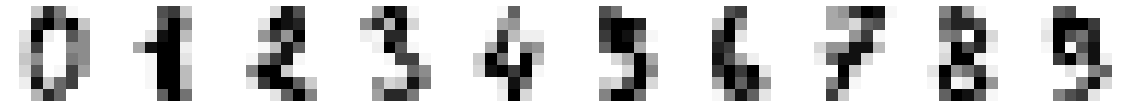

In [33]:
from sklearn.datasets import load_digits

digits = load_digits()

print('data shape:', digits.data.shape)
print('max data =', np.max(digits.data))
print('labels[0..9] =', digits.target[:10])
print('data[0] =')
for row in range(8):
    print('\t'.join(str(int(d)) for d in digits.data[0][row * 8 : (row + 1) * 8]))

def plot_sample_digits(blur = False):
    plt.figure(figsize = (20, 4))
    for index, image in enumerate(digits.data[:10], 1):
        plt.subplot(1, 10, index, xticks = [], yticks = [])
        plt.imshow(image.reshape((8, 8)), interpolation = 'spline36' if blur else None)
        
plot_sample_digits()

Let's try to teach the computer another very human task - handwriting recognition.

This data set contains images of hand-written digits, with a label that shows what digit each row represents.

Let's look at a few properties of the data.  There are 1797 rows, each row a 64-element array, or a flattened 8-by-8 grid.  Values range from 0 to 16 and represent the amount of ink in each cell of the grid.  Here are the first ten rows, displayed as pictures.

It's a bit hard to read, but I can blur these images, which, paradoxically, makes them easier to read.

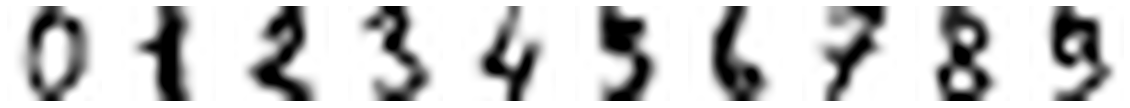

In [34]:
plot_sample_digits(blur = True)

By the way, this technique - blurring images to make them easier to recognize - helps not just humans, but also machine learning algorithms.  But that would take an additional hour to explain.

Anyway, here are our digits, and here is a new challenge.  There're not two different labels.  There are ten.  We need to recognize ten different digits.  Everything we did so far only dealt with binary labels.  The whole nature of the sigmoid formula - construct a linear combination of features and see if it's greater or less than zero - this does not work here.  What do we do?

We reduce our problem to the already solved one.  We build a binary classifier.  To be more precise, we build ten binary classifiers.  Classifier number zero will detect the probability that the input array represents a zero, and not some other digit.  Classifier number one will measure the probability that the digit is one.  Classifier number two is an expert on hand-written twos. And so on.  When we have all ten models trained, we run each one of them on our input, and then pick the prediction with the highest probability.  This is called the one-vs-all approach.

For this, we need to modify our labels.  Instead of numbers 0 through 9, we need a separate set of labels to train each classifier.  Classifier zero should be trained on the entire data set, using a list of 1797 labels, where the label is 1 if and only if the digit is zero.  Classifier, say, seven is trained on all data with the list of labels that is 1 for every row that represents a 7, and zero otherwise.

This should sound familiar to you.

This is one-hot-encoding, only in this case, we apply it not to the data, but to the labels.

In [35]:
Y = pd.get_dummies(digits.target)
print(digits.target[:10], Y[:10], sep = '\n\n')

[0 1 2 3 4 5 6 7 8 9]

   0  1  2  3  4  5  6  7  8  9
0  1  0  0  0  0  0  0  0  0  0
1  0  1  0  0  0  0  0  0  0  0
2  0  0  1  0  0  0  0  0  0  0
3  0  0  0  1  0  0  0  0  0  0
4  0  0  0  0  1  0  0  0  0  0
5  0  0  0  0  0  1  0  0  0  0
6  0  0  0  0  0  0  1  0  0  0
7  0  0  0  0  0  0  0  1  0  0
8  0  0  0  0  0  0  0  0  1  0
9  0  0  0  0  0  0  0  0  0  1


In case that was confusing, here's the illustration for the first ten labels.  The labels are 0 through nine.  The one-hot-encoded array has ones in correct locations: for the label zero, the zeroth column starts with the one, to indicate that zero is indeed the correct label, and then has only zeros, because there are no other zeros in this little sample.  We will use this zeroth column to train our model number zero, the one that specializes in recognizing zeros.  The column number one only has a single one in it.  It corresponds to the next digit, which is indeed one.  All the other entries in this column one are zeros.  Etc.

Now we are done with the labels for our eventual ten classifiers, and are ready to perepare our data.

In [36]:
X = add_constant(digits.data / 16)
X_train, X_test, Y_train, Y_test, target_train, target_test = train_test_split(
    X, Y, digits.target, train_size = 0.9, random_state = 1001)

We scale the data by dividing it by the largest value.  Then we append the bias column.  Then we are done, and can run logistic regression training ten times.

In [37]:
models = []
print('digit', 'acc', 'dominant label frequency', sep = '\t')
for i in range(10):
    digit_model = gradient_descent(X_train, Y_train[i], np.zeros(X_train.shape[1]), 20000, 1.0)
    acc = accuracy(X_test, digit_model, Y_test[i])
    dominant_label_frequency = 1 - np.mean(Y_test[i])
    print('{}\t{:.3f}\t{:.3f}'.format(i, acc, dominant_label_frequency))
    models.append(digit_model)

digit	acc	dominant label frequency
0	1.000	0.878
1	0.972	0.883
2	1.000	0.911
3	0.978	0.911
4	1.000	0.928
5	0.994	0.917
6	0.994	0.894
7	0.994	0.883
8	0.944	0.872
9	0.994	0.922


We run a loop, training a dedicated model for each digit.  Notice how at every iteration we do not change the input data X - what we change is the labels Y, using the correct column for each digit.

At each iteration, I compute the dominant label frequency - because training ten classifiers that say "No" to everything they are asked to classify is as easy as it is useless - and you can see the accuracy is much higher than the dominant frequency.

You might have noticed I've been spending less and less time examining the weights of our models, and concentrating more and more on the predictions we can get out of those models.  It happens to be the case that the more complex models have more weights, and it is increasingly less useful to look at those weights directly.  Let's do this one more time, mostly for curiosity's sake.

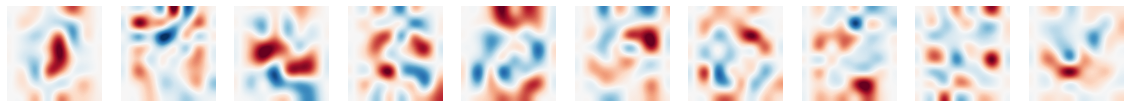

In [38]:
plt.figure(figsize = (20, 4))
for index, model in enumerate(models, 1):
    scale = np.abs(model[1:]).max()
    plt.subplot(1, 10, index, xticks = [], yticks = [])
    plt.imshow(model[1:].reshape((8, 8)), cmap = 'RdBu', vmin = -scale, vmax = scale, interpolation = 'spline36')

Here are the weights, and they are sort of informative.  Blue is for positive match: these pixels' presence increase the chance of positive classification; red is for negative match.  Notice how the classifier that is trained to identify zeroes is looking for pixels in a circle, and penalizes pixels elsewhere.  The classifier for the digit 6 looks for a small circle in the bottom-left of the image.  The classifier for 8 looks for an X-like intersection in the middle of the image.

Now that we have our ten models, we are just about done.  When we receive an image of a hand-written digit to classify, all we need to do is to run ten predictions.  Applying a model to input data simply involves multiplying the data values by the model weights, adding up the results, and picking the model with the highest result.  I can do this in one line of code.

In [39]:
def classify_digit(d):
    return np.argmax([d.dot(model) for model in models])

predictions = list(map(classify_digit, X_test))
correct = [prediction == label for prediction, label in zip(predictions, target_test)]
print('correct = {}, incorrect = {}, accuracy = {:.3f}\n'.format(
    sum(correct), len(correct) - sum(correct), np.mean(correct)))

correct = 175, incorrect = 5, accuracy = 0.972



This is the actual classifier: multiply the input data by each model's weights, and pick the model with the highest score.

When we apply this to the test set - remember, this the the data that our model has never seen before, containing hand-written digits that are likely written in a different handwriting! - we get over 97% percent accuracy.  This is roughly human-level performance on a human-level task, which would have been hugely difficult to code without machine learning.  And this classifier not only is almost always correct, but it is confidently correct.

0	0.0
1	0.0
2	0.0
3	0.0016
4	0.0
5	0.2656
6	0.0
7	0.0
8	0.0003
9	0.4073


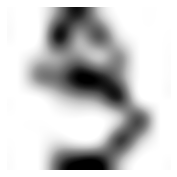

true label: 9


In [40]:
for i, confidence in enumerate(sigmoid(X_test[100].dot(model)) for model in models):
    print(i, round(confidence, 4), sep = '\t')

plt.figure(figsize = (4, 3))
plt.imshow(X_test[100][1:].reshape((8, 8)), interpolation = 'spline36')
plt.xticks([])
plt.yticks([])
plt.show()

print('true label:', target_test[100])

It took me some time to find a digit in the training set that was ambiguous.  Here it is.  This is supposed to be a 9, but  it also sort of looks like a 3 or a 5.  If I display the probabilities from each model, we see that the model is only 40% certain this is a nine - but every other probability is much smaller, the runner-up being the digit 5, with 27% confidence.  This is classified correctly.

Notice that probabilities do not add up to one.  This is because they have been trained independently.  We'll solve this issue the next time.

By the way, if your images are in color, nothing changes.  You just flatten a three-dimensional array: widths, height, and three color channels, red, green, and blue.

The next slide is my favorite, even though it does not teach anything new.  Since I've demonstrated building a logistic regression classifier step by step, it's easy to lose track of the amount of all work needed.  I am now going to put all the code on one slide: loading the data, preparing the features, defining gradient descent, and training the models.  I will also reduce my reliance on the libraries I import.  I will write out the code that appends bias, and also the code that applies one-hot-encoding to the labels.  I will only use one library for matrix operations, and another library to load the data set.

That said, how many lines of code do you think we need to write an entire logistic regression classifier from scratch - including data preprocessing, training, and running inference?  60 lines of code?  40?  25?

The answer is: 9.

In [41]:
import numpy as np, sklearn.datasets

def gradient_descent(X, Y, W, epochs, learning_rate):
    for _ in range(epochs):
        W = W - learning_rate * (1 / (1 + np.exp(-X @ W)) - Y).dot(X) / len(X)
    return W

digits = sklearn.datasets.load_digits()
X, Y = np.hstack([digits.data / 16, np.ones((len(digits.data), 1))]), np.eye(10)[digits.target].T
models = [gradient_descent(X, Y[i], np.zeros(X.shape[1]), 20000, 1.0) for i in range(10)]

print('label = {}, prediction = {}'.format(digits.target[1], np.argmax([X[1].dot(model) for model in models])))

label = 1, prediction = 1


This never ceases to amaze me how this tiny bit of code can be so powerful and so versatile.  I'm going to leave this on the screen for another minute while we review.

What have we learned today?  We can take a data set; designate one categorical column as a label; use other columns as features; and train a logistic regression model that can predict the label for the previously unseen rows of data.  The label itself can be binary or it can have multiple values; in the latter case, we can build multiple one-vs-all classifiers.  The features can be numeric; they can be categorical.  If they are categorical but binary, we leave them as they are; if they have more than two values we use one-hot-encoding.  We know how to translate images into numerical data.  We know how to use the bag-of-words model to encode text.  By the way, all of these techniques apply not only to logistic regression, but also to our old friend linear regression - after all, logistic regression is simply linear regression wrapped in a sigmoid.

As I've mentioned last week, you don't need to run my code.  There are plenty of software packages that would run logistic regression for you.

In [42]:
np.round(gradient_descent(titanic_one_hot.values, titanic['survived'],
                          np.zeros(len(titanic_one_hot.columns)), 50000, 0.1), 3)

array([ 0.858, -0.16 , -0.92 , -1.062, -2.42 ,  2.248])

This is the code you've seen, applied to the Titanic data set.  The input has been one-hot-encoded already, and the bias column added.

In [43]:
import statsmodels.api as stats

# See http://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html

stats_logistic_model = stats.GLM(titanic['survived'], titanic_one_hot, family = stats.families.Binomial()).fit()
stats_logistic_model.params

class_1       0.858
class_2      -0.160
class_3      -0.920
is_adult_1   -1.062
is_male_1    -2.420
bias          2.248
dtype: float64

This is statsmodels, applied to the same inpug.  GLM stands for Generalized Linear Model.  Binomial family means the label is binary.

In [44]:
from sklearn.linear_model import LogisticRegression

# See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

scikit_logistic_model = LogisticRegression(fit_intercept = False, solver = 'liblinear', C = 10000).fit(
    titanic_one_hot, titanic['survived'])
np.round(scikit_logistic_model.coef_, 3)

array([[ 0.858, -0.16 , -0.92 , -1.062, -2.42 ,  2.248]])

This is sci-kit.  This method adds bias by default, so we need to tell it not to.  The weights are the same, of course.

Finally, we can bring out big guns and use TensorFlow.

In [45]:
import tensorflow as tf

tf_lin_model = tf.keras.Sequential([tf.keras.layers.Dense(1,
                                                          input_dim = titanic_one_hot.shape[1],
                                                          use_bias = False,
                                                          activation = 'sigmoid',
                                                          kernel_initializer = 'zeros')])
tf_lin_model.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.02), loss = 'binary_crossentropy')
tf_lin_model.fit(titanic_one_hot.values,
                 titanic['survived'].values,
                 epochs = 5000, verbose = 0)

W = tf_lin_model.get_layer(index = 0).get_weights()

print(np.round(W, 3))

tf.keras.backend.clear_session()

[[[ 0.858]
  [-0.16 ]
  [-0.92 ]
  [-1.061]
  [-2.421]
  [ 2.247]]]


TensorFlow is hugely powerful, which is why it needs to be told exactly what to do: do not use bias, compute a linear combination of inputs and then apply the sigmoid, initialize the weights to zero, run gradient desent, use the logistic loss - here called "binary crossentropy".

At this point, we have enough knowledge to start discussing neural networks.  With a single elementary trick, the powers we've developed so far will turn into superpowers.  This means that the next week we'll be, on the easy side, mostly looking at the pictures of sandwiches.  On the hard side, we'll encounter the single most difficult data set in the entirely history of machine learning.

Thank you for your attention.